In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

C:\Users\sanke\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_lfw.py:353: UserWarning: Persisting input arguments took 1.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  faces, target, target_names = load_func(


['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


Use the following code to show the first several images in the dataset and the people to whom the faces belong.

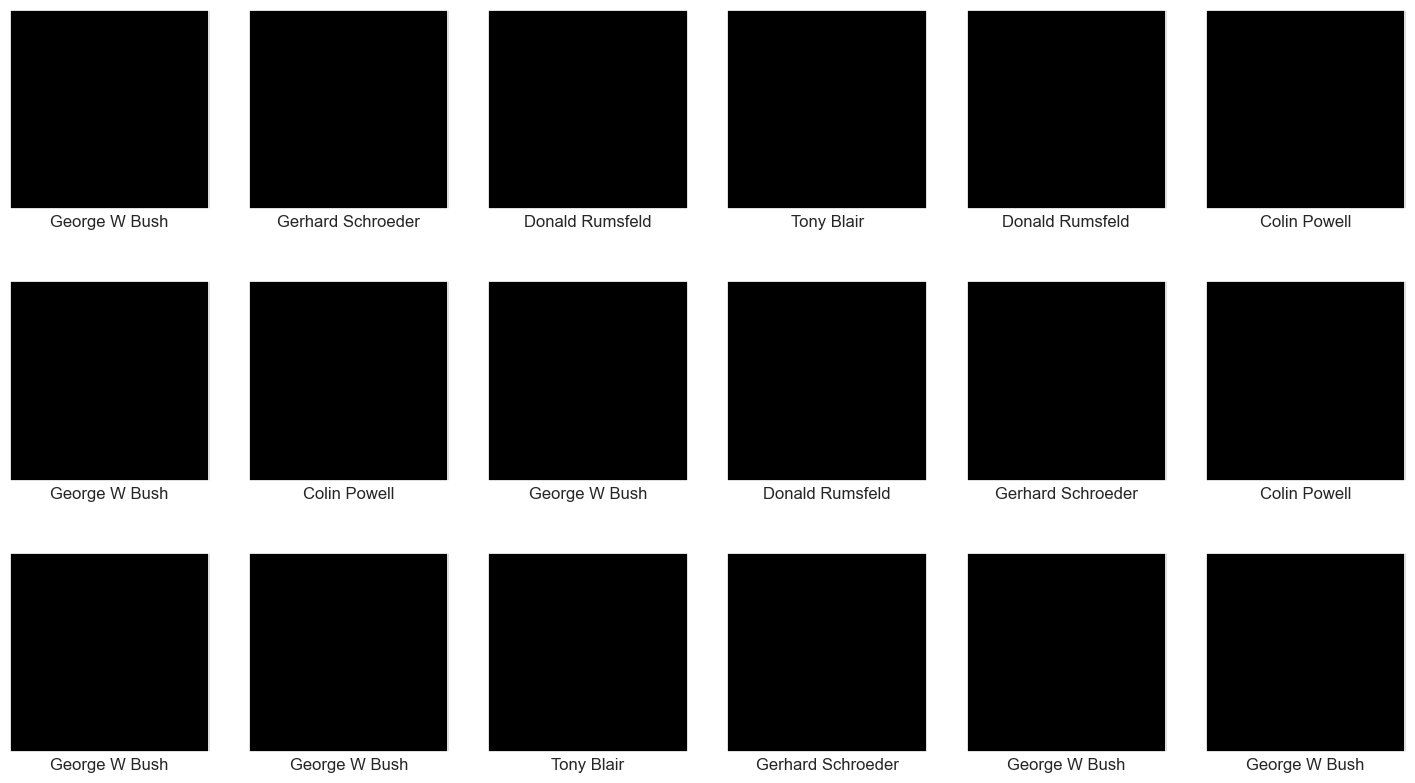

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each of the five persons, or classes, that the CNN will try to predict.

<Axes: >

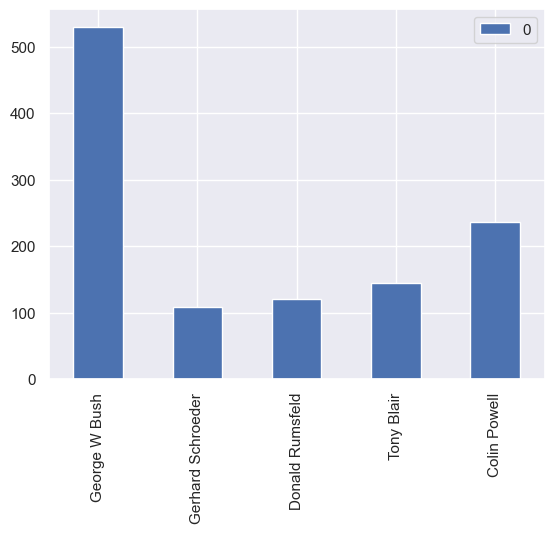

In [4]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

Classification models are best trained with balanced datasets. Use the following code to build a dataset containing 100 images of each person.

In [6]:

mask = np.zeros(faces.target.shape, dtype=np.bool_)


for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(500, 128, 128, 3)

The next step is to preprocess pixel values the way `ResNet50` expects and convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) them. Then split the data for training and testing.

In [7]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

In [8]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

94765736/94765736 [==============================] - 43s 0us/step


Now add classification layers to the base model and include a `Resizing` layer to resize images input to the network to 224x224.

Call `fit` to train the model.

In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=5)

Epoch 1/5
 3/40 [=>............................] - ETA: 21:24 - loss: 34.5735 - accuracy: 0.2000

Plot the training and validation accuracy to see how well the network performed.

[]

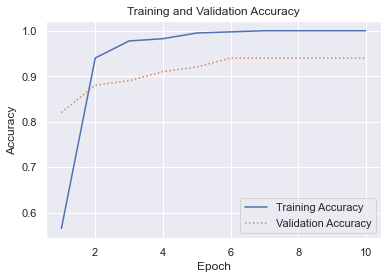

In [9]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run some test data through the network and use a confusion matrix to see how it fared.

Text(89.18, 0.5, 'Actual label')

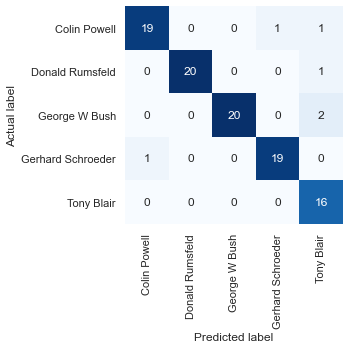

In [10]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

How many times did the network correctly identify George W. Bush? How many times did it fail to identify him?

In [11]:
from keras_vggface.vggface import VGGFace

base_model = VGGFace(model='resnet50', include_top=False)
base_model.trainable = False

Add classification layers to the base model and include a `Resizing` layer to resize images input to the network to 224x224.

In [12]:
model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Call `fit` to train the model.

In [13]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
40/40 [==============================] - 26s 310ms/step - loss: 0.6587 - accuracy: 0.8617 - val_loss: 4.7684e-09 - val_accuracy: 1.0000
Epoch 2/10
40/40 [==============================] - 9s 235ms/step - loss: 9.7264e-08 - accuracy: 1.0000 - val_loss: 1.3113e-08 - val_accuracy: 1.0000
Epoch 3/10
40/40 [==============================] - 10s 242ms/step - loss: 5.8691e-09 - accuracy: 1.0000 - val_loss: 8.3446e-09 - val_accuracy: 1.0000
Epoch 4/10
40/40 [==============================] - 10s 246ms/step - loss: 5.6670e-08 - accuracy: 1.0000 - val_loss: 3.5763e-09 - val_accuracy: 1.0000
Epoch 5/10
40/40 [==============================] - 10s 243ms/step - loss: 1.2922e-08 - accuracy: 1.0000 - val_loss: 2.3842e-09 - val_accuracy: 1.0000
Epoch 6/10
40/40 [==============================] - 10s 243ms/step - loss: 7.3767e-09 - accuracy: 1.0000 - val_loss: 2.3842e-09 - val_accuracy: 1.0000
Epoch 7/10
40/40 [==============================] - 10s 244ms/step - loss: 1.7012e-09 - accuracy: 1

Plot the training and validation accuracy to see how well the network performed.

[]

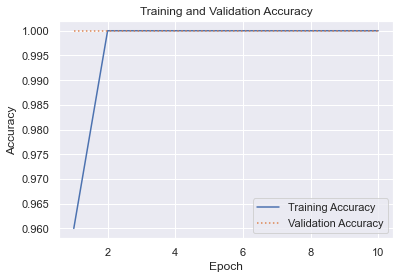

In [14]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run some test data through the network and use a confusion matrix to see how it fared.

Text(89.18, 0.5, 'Actual label')

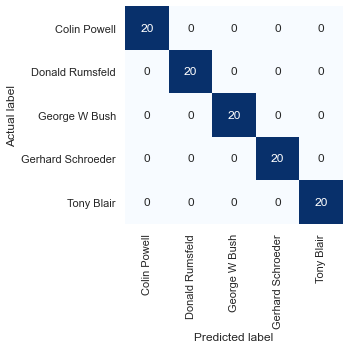

In [15]:
y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Loaded with weights optimized for extracting features from faces, `ResNet50` is *much* better at recognizing faces than the same network initialized with ImageNet weights. One of the lessons here is that transfer learning using task-specific weights is typically better than transfer learning using generic weights.

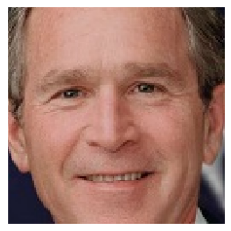

In [16]:
from keras.preprocessing import image

x = image.load_img('Data/george.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Now see if the network can identify the person in the picture.

In [17]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
y = model.predict(x)[0]

for i in range(len(y)):
    print(faces.target_names[i] + ': ' + str(y[i]))

Colin Powell: 2.523034e-35
Donald Rumsfeld: 1.4205743e-33
George W Bush: 1.0
Gerhard Schroeder: 1.758811e-19
Tony Blair: 0.0


Did it correctly identify the face as that of George W. Bush? How confident was it in its prediction?